# Convolutional Neural Networks: InceptionNet & DenseNet

In this notebook, we will design and train simplified **InceptionNet** and **DenseNet** on [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), which is easily available through [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.CIFAR10). 
Note that InceptionNet was originally trained on ImageNet dataset which is much larger and requires more computational resources.
**To prevent overfitting issues, we will size down the InceptionNet as well as introduce data augmentation.**

We will also implement DenseNet from [Huang et al.](https://arxiv.org/pdf/1608.06993.pdf). 

*Below is the description of this dataset as on [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) website*

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each:

<img src="img/cifar.png" width=500>

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

### Setup

For this tutorial, we will need the following python packages 

1. numpy
2. matplotlib
3. torch
4. torchvision

Please follow the instructions [here](https://pytorch.org/) to install the last two libraries. 

In [1]:
# basic imports
import numpy as np
import matplotlib.pyplot as plt
import math
import pathlib

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from matplotlib.lines import Line2D

from collections import defaultdict

# fix seed for reproducibility 
rng = np.random.RandomState(1)
torch.manual_seed(rng.randint(np.iinfo(int).max))

# it is a good practice to define `device` globally
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", device)
else:
    device = torch.device("cpu")
    print("No GPU -> using CPU:", device)


Using GPU: cuda


### Data

PyTorch has simple-to-use functions that downloads and loads the datasets. We will use these functions to streamline our deep learning pipeline.

Checkout other image datasets at [torch.datasets](https://pytorch.org/vision/stable/datasets.html).

In [2]:
# download data in data folder. It will create this folder if it doesn't exist
torchvision.datasets.CIFAR10(root="./data/", download=True)

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/
    Split: Train

### Explore Data

We will be carrying out simple investigations as we did in the practical of denoising autoencoders. 
Specifically, we are interested in finding out the following :

How does the data look like?

- What is the `type` of data?
- What does each element of data represent?
- What are the constituent parts of each element?
- How is the image represented?
- What do we use to plot an image?
- How do we use the image in our model?

In [3]:
# load data 
data = torchvision.datasets.CIFAR10(root="./data/", train=True) # only load training data

For the ease of referencing, we will create a dictionary mapping the category number to the category label.

In [4]:
CATEGORY_MAPPING = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

In [5]:
print("Type of data is the class\n", type(data))
print("\nEach element of the data is\n", type(data[0]))
print("\nA single element is\n", data[0],"\n\nfirst element is the image and the second element is the category")
print(f"\nImage size in tensor form is accessible through data.data[idx].shape e.g.: {data.data[0].shape}")

Type of data is the class
 <class 'torchvision.datasets.cifar.CIFAR10'>

Each element of the data is
 <class 'tuple'>

A single element is
 (<PIL.Image.Image image mode=RGB size=32x32 at 0x7FF60083FE10>, 6) 

first element is the image and the second element is the category

Image size in tensor form is accessible through data.data[idx].shape e.g.: (32, 32, 3)


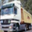

In [6]:
# original sized image as displayed in jupyter notebook
data[1][0]

### Image data

We will use `.data` attribute of `torchvision.datasets.CIFAR10` to access the images in tensor format.
We will use [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) to appropriately transform the data to be further processed by our CNN. 

Min value: 30 	 Max value:242
Category number: 8 	 Category label: ship


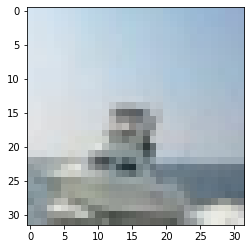

In [7]:
idx = 100

img = data.data[idx]

print(f"Min value: {img.min()} \t Max value:{img.max()}")

# how to display the image 
plt.imshow(img)
print(f"Category number: {data[idx][1]} \t Category label: {CATEGORY_MAPPING[data[idx][1]]}")

In [8]:
reverse_cat_map = defaultdict(list)
for idx, (_, c) in enumerate(data):
    reverse_cat_map[c].append(idx)

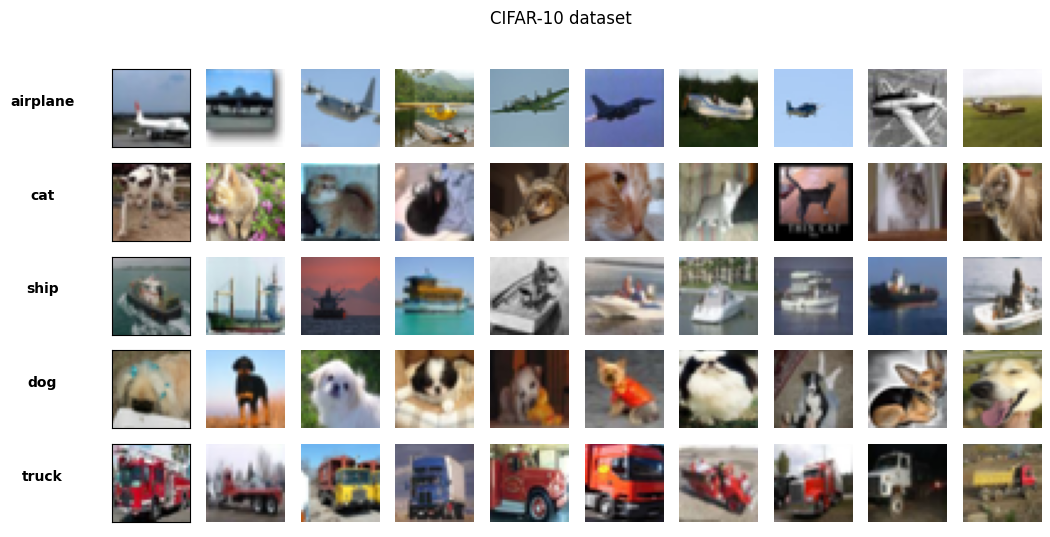

In [9]:
# visualize
n_samples = len(data)

ncats = np.random.choice(list(CATEGORY_MAPPING.keys()), size=5) # number of categories
ncols = 10 # images per category
fig, axs = plt.subplots(nrows=len(ncats), ncols=ncols, figsize=(12,6), dpi=100)

for row, cat in enumerate(ncats):
    idxs = reverse_cat_map[cat]
    idxs = np.random.choice(idxs, size=ncols)
    
    # title 
    axs[row][0].set_ylabel(CATEGORY_MAPPING[cat], fontweight="bold", rotation=0, labelpad=50)
    for i in range(ncols):
        ax = axs[row][i]
        ax.imshow(data[idxs[i]][0])
        ax.axis('off')
    axs[row][0].axis('on')
    axs[row][0].xaxis.set_ticks([])
    axs[row][0].yaxis.set_ticks([])

_ = fig.suptitle(f"CIFAR-10 dataset")

## Inception Block

In this tutorial, instead of building the GoogleNet ditto, we will focus on the basics of InceptionNet. 
Specifically, we will learn how to build an Inception Block and arrange several of these blocks to form an InceptionNet. 

As a refresher, the inception block as described by Szegedy et al. consists of several convolutions of size 1,3, and 5 along with max pooling layers. 
This allows the network to process images at different receptive fields. 


<img src="img/inception_block.svg" width=1000>

[[Szegedy et al. 2014] Going deeper with convolutions](https://arxiv.org/pdf/1409.4842.pdf)

In [13]:
class InceptionBlock(nn.Module):
    """
    Implements a basic inception block 
    
    Args:
        c_in (int): Number of channels in the input 
        c_reduce (dict): dictionary mapping dimension reduction for each of the 3x3 and 5x5 convolutions. Keys are '3x3' and '5x5'.
        c_out (dict): dictionary mapping final number of channels for each of the convolutions. Keys are '1x1', '3x3', '5x5', and 'maxpool'
    """
    def __init__(self, c_in, c_reduce, c_out):
        super(InceptionBlock, self).__init__()
        
        # 1x1
        self.conv1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out['1x1'], kernel_size=1),
            nn.BatchNorm2d(c_out['1x1']),
            nn.ReLU(),
        )
        
        # 3x3 
        self.conv3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_reduce['3x3'], kernel_size=1),
            nn.BatchNorm2d(c_reduce['3x3']),
            nn.ReLU(),
            nn.Conv2d(c_reduce['3x3'], c_out['3x3'], kernel_size=3, padding=1), # Keep the size same
            nn.BatchNorm2d(c_out['3x3']),
            nn.ReLU()
        )
        
        # 5x5 
        self.conv5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_reduce['5x5'], kernel_size=1),
            nn.BatchNorm2d(c_reduce['5x5']),
            nn.Conv2d(c_reduce['5x5'], c_out['5x5'], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out['5x5']),
            nn.ReLU()
        )
        
        # max-pool
        self.pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1), # keeps the final outputs' size same
            nn.Conv2d(c_in, c_out['maxpool'], kernel_size=1),
            nn.BatchNorm2d(c_out['maxpool']),
            nn.ReLU()
        )
    
    def forward(self, x):
        x1 = self.conv1x1(x)
        x2 = self.conv3x3(x)
        x3 = self.conv5x5(x)
        x4 = self.pool(x)
        return torch.cat([x1, x2, x3, x4], dim=1)

## (Shallow) InceptionNet 

Szegedy et al. used the following configuration for GoogleNet with 7M parameters. ImageNet's images are of the size 3 x 224 x 224.

<img src="img/inception-net.png" width=1000>


Since we are training on a smaller CIFAR10 dataset with images of size 3 x 32 x 32, we will use a smaller InceptionNet with the following configration

[[Szegedy et al. 2014] Going deeper with convolutions](https://arxiv.org/pdf/1409.4842.pdf)


We will reduce the size of the output channels from the above table by a factor of 4, and restrict the depth to 1 for all the blocks. Resulting in the following configuration - 


|      type     	| patch size <br>/ stride 	|  output <br>  size  	| depth 	| # 1x1 	|  #3x3 <br>reduce 	| #3x3 	|  #5x5 <br>reduce 	| #5x5 	| pool<br>proj 	|
|:-------------:	|:-----------------------:	|:-------------------:	|:-----:	|:-----:	|:----------------:	|:----:	|:----------------:	|:----:	|:------------:	|
|  convolution  	|          3x3/1          	|     32 x 32 x 16    	|   1   	|   -   	|         -        	|   -  	|         -        	|   -  	|       -      	|
|  convolution  	|          3x3/1          	|     32 x 32 x 48    	|   1   	|   -   	|         -        	|   -  	|         -        	|   -  	|       -      	|
| inception(3a) 	|            -            	|     32 x 32 x 64    	|   1   	|   16  	|        24        	|  32  	|         4        	|   8  	|       8      	|
| inception(3b) 	|            -            	|     32 x 32x 120    	|   1   	|   32  	|        32        	|  48  	|         8        	|  24  	|      16      	|
|    maxpool    	|          3x3/2          	|    16 x 16 x 120    	|   -   	|   -   	|         -        	|   -  	|         -        	|   -  	|       -      	|
| inception(4a) 	|                         	|    16 x 16 x 128    	|   1   	|   48  	|        24        	|  52  	|         4        	|  12  	|      16      	|
| inception(4b) 	|                         	|    16 x 16 x 128    	|   1   	|   40  	|        28        	|  56  	|         6        	|  16  	|      16      	|
| inception(4c) 	|                         	|    16 x 16 x 128    	|   1   	|   32  	|        32        	|  64  	|         6        	|  16  	|      16      	|
| inception(4d) 	|                         	|    16 x 16 x 132    	|   1   	|   28  	|        36        	|  72  	|         8        	|  16  	|      16      	|
| inception(4e) 	|                         	|    16 x 16 x 208    	|   1   	|   64  	|        40        	|  80  	|         8        	|  32  	|      32      	|
|    maxpool    	|          3x3/2          	|     8 x 8 x 208     	|   -   	|   -   	|         -        	|   -  	|         -        	|   -  	|       -      	|
| inception(5a) 	|                         	|     8 x 8 x 208     	|   1   	|   64  	|        40        	|  80  	|         8        	|  32  	|      32      	|
| inception(5b) 	|                         	|     8 x 8 x 256     	|   1   	|   96  	|        48        	|  96  	|        12        	|  32  	|      32      	|
|    avg pool   	|          8x8/1          	|     1 x 1 x 256     	|       	|       	|                  	|      	|                  	|      	|              	|
|  dropout(40%) 	|                         	|     1 x 1 x 256     	|       	|       	|                  	|      	|                  	|      	|              	|
|     linear    	|                         	|     1 x 1 x 128     	|       	|       	|                  	|      	|                  	|      	|              	|
|    softmax    	|                         	|      1 x 1 x 10     	|       	|       	|                  	|      	|                  	|      	|              	|

In [14]:
class ShallowInceptionNet(nn.Module):
    def __init__(self, c_in, num_classes=10):
        super().__init__()
        
        self.input_args = [c_in]
        
        # 
        self.input_conv = nn.Sequential(
            ## conv1 
            nn.Conv2d(c_in, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            ## conv2
            nn.Conv2d(16, 48, kernel_size=3, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
        )
        
        # inception blocks 
        self.inception_stack = nn.Sequential(
            InceptionBlock(48, c_reduce={'3x3': 24, '5x5':4}, c_out={'1x1':16, '3x3':32, '5x5':8, 'maxpool':8}), # 3a
            InceptionBlock(64, c_reduce={'3x3': 32, '5x5':8}, c_out={'1x1':32, '3x3':48, '5x5':24, 'maxpool':16}), # 3b
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), # maxpool-1
            InceptionBlock(120, c_reduce={'3x3': 24, '5x5':4}, c_out={'1x1':48, '3x3':52, '5x5':12, 'maxpool':16}), # 4a
            InceptionBlock(128, c_reduce={'3x3': 28, '5x5':6}, c_out={'1x1':40, '3x3':56, '5x5':16, 'maxpool':16}), # 4b
            InceptionBlock(128, c_reduce={'3x3': 32, '5x5':6}, c_out={'1x1':32, '3x3':64, '5x5':16, 'maxpool':16}), # 4c
            InceptionBlock(128, c_reduce={'3x3': 36, '5x5':8}, c_out={'1x1':28, '3x3':72, '5x5':16, 'maxpool':16}), # 4d
            InceptionBlock(132, c_reduce={'3x3': 64, '5x5':8}, c_out={'1x1':64, '3x3':80, '5x5':32, 'maxpool':32}), # 4e
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1), # maxpool-1
            InceptionBlock(208, c_reduce={'3x3': 40, '5x5':8}, c_out={'1x1':64, '3x3':80, '5x5':32, 'maxpool':32}), # 5a
            InceptionBlock(208, c_reduce={'3x3': 48, '5x5':12}, c_out={'1x1':96, '3x3':96, '5x5':32, 'maxpool':32}), # 5b                    
        )
        
        # output module 
        self.output_softmax = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1,1)), # kernel_size and stride are automaticall inferred: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
            nn.Dropout(0.4),
            nn.Flatten(),
            nn.Linear(256, num_classes),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        x = self.input_conv(x)
        x = self.inception_stack(x)
        x = self.output_softmax(x)
        return x
        


In [10]:
input_shape = data.data[0].shape # width, height,  number of channels, 
print(input_shape)

(32, 32, 3)


We need to write a function to fetch the memory statistics of our model.
While building different autoencoder models, it will be important to ensure they have all similar number of learnable parameters. This will ensure fair comparison of their performance.

In [15]:
def mem_size(model):
    """
    Get model size in GB (as str: "N GB")
    """
    mem_params = sum(
        [param.nelement() * param.element_size() for param in model.parameters()]
    )
    mem_bufs = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])
    mem = mem_params + mem_bufs
    return f"{mem / 1e9:.4f} GB"

def num_params(model):
    """
    Print number of parameters in model's named children
    and total
    """
    s = "Number of parameters:\n"
    n_params = 0
    for name, child in model.named_children():
        n = sum(p.numel() for p in child.parameters())
        s += f"  • {name:<15}: {n}\n"
        n_params += n
    s += f"{'total':<19}: {n_params}"

    return s

def pp_model_summary(model):
    print(num_params(model))
    print(f"{'Total memory':<18} : {mem_size(model)}")

In [16]:
model = ShallowInceptionNet(c_in=input_shape[2])
pp_model_summary(model)

Number of parameters:
  • input_conv     : 7536
  • inception_stack: 367068
  • output_softmax : 2570
total              : 377174
Total memory       : 0.0015 GB


### Data Transformation


Standard ways to transform image datasets has majorly involved two components:

- **Data normalization**: It is a standard practice to make sure that all input dimensions are on the same scale. We will use [`transforms.normalize`](https://pytorch.org/vision/stable/transforms.html#conversion-transforms) for this purpose.
    
    
- **Data augmentation**: Given that an image category remains same if it is cropped (a little) or rotated, we want the network to be robust to these changes. Not only it makes for a better classifier it also prevents network from overfitting to the original dataset. Therefore, we will be doing random cropping followed by resizing and flipping of the images. This is conveniently handled by [`transforms.RandomCrop`](https://pytorch.org/vision/stable/_modules/torchvision/transforms/transforms.html#RandomCrop) and [`transforms.RandomHorizontalFlip`](https://pytorch.org/vision/stable/_modules/torchvision/transforms/transforms.html#RandomHorizontalFlip). Note that we can use other transformations as well. 
    
**Note**: We don't need to apply the above augmentation transformations on the test dataset. 

We will define these transforms here for convenience. 

In [17]:
DATA_MEANS =  (data.data / 255.0).mean(axis=(0,1,2))
DATA_STD = (data.data / 255.0).std(axis=(0,1,2))

print(f"data means along three channels: {DATA_MEANS}")
print(f"data std along three channels: {DATA_STD}")

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=(input_shape[0], input_shape[1]), ratio=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_MEANS, std=DATA_STD)
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=DATA_MEANS, std=DATA_STD)
])

data means along three channels: [0.49139968 0.48215841 0.44653091]
data std along three channels: [0.24703223 0.24348513 0.26158784]


### Dataset loading

[`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) conveniently takes these transforms to provide us with a dataloader for iterating through the dataset.

In [18]:
# train dataset with transforms
train_data = torchvision.datasets.CIFAR10(root="./data/", transform=train_transforms)

# split data into train and val; we will create train_data at the start of every epoch
x_train, x_val = torch.utils.data.random_split(train_data, [45000, 5000]) # 10% train-val split
val_dataloader = torch.utils.data.DataLoader(x_val, batch_size=256, shuffle=True)

# test dataset with transforms
test_data = torchvision.datasets.CIFAR10(root="./data/", transform=test_transforms)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=256, num_workers=4)

/home/mila/g/guptapra/deepkoopman/dkenv/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
def process(model, dataloader, optimizer=None):
    n_samples = 0
    running_loss, running_acc = 0, 0
    for batch, labels in dataloader:
        # transfer to GPU if avaiable
        batch = batch.to(device)
        labels = labels.to(device)

        n_samples += batch.shape[0]
        
        # forward pass
        outputs = model(batch)
        loss = nn.CrossEntropyLoss()(outputs, labels) # reconstruction loss
        preds = outputs.argmax(dim=1)
        
        # backward pass 
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()
        running_acc += (preds == labels).sum().float().item()
        
    return running_loss / n_samples, running_acc / n_samples
        
    

In [26]:
def train(model):
    model.to(device)
    
    # fix seed for reproducibility 
    rng = np.random.RandomState(1)
    torch.manual_seed(rng.randint(np.iinfo(int).max))

    # create a model directory to store the best model
    model_dir = pathlib.Path("./models").resolve()
    if not model_dir.exists():
        model_dir.mkdir()

    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

    epoch_size=200
    batch_size=128

    best_val_acc = 0
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    n_epochs = 30
    no_improvement_cnt = 0
    for epoch in range(n_epochs):
        print(f"@ epoch {epoch}", end="")

        # training loss
        idxs = rng.choice(len(x_train), epoch_size * batch_size, replace=True)
        train_dataloader = torch.utils.data.DataLoader([x_train[idx] for idx in idxs], batch_size=batch_size, num_workers=4)
        train_loss, train_acc = process(model, train_dataloader, optimizer)

        # validation loss
        with torch.no_grad():
            val_loss, val_acc = process(model, val_dataloader)

        # save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_dir / f"best_{model.__class__.__name__}.ckpt")
            no_improvement_cnt = 0
        else:

            # if there has been no improvement in validation loss, stop early
            no_improvement_cnt += 1

            if no_improvement_cnt % 10 == 0:
                print("\nEarly stopping!")
                break

        # logging
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"\ttrain_loss: {train_loss: .5f}, train_acc:{100*train_acc: 2.3f}%,  val_loss: {val_loss:.5f}, val_acc:{100*val_acc: 2.3f}%,")

    print(f"best val acc: {100*best_val_acc:2.3f}%")

    # load the best model
    model = model.__class__(*model.input_args)
    model.load_state_dict(torch.load(model_dir /  f"best_{model.__class__.__name__}.ckpt"))
    model = model.to(device) 
    
    metrics = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }
    return model, metrics


In [19]:
model = ShallowInceptionNet(c_in=input_shape[2])
model, metrics = train(model)

@ epoch 0	train_loss:  0.01687, train_acc: 29.242%,  val_loss: 0.00849, val_acc: 32.680%,
@ epoch 1	train_loss:  0.01632, train_acc: 36.836%,  val_loss: 0.00825, val_acc: 39.380%,
@ epoch 2	train_loss:  0.01592, train_acc: 42.113%,  val_loss: 0.00814, val_acc: 42.600%,
@ epoch 3	train_loss:  0.01565, train_acc: 45.664%,  val_loss: 0.00805, val_acc: 44.020%,
@ epoch 4	train_loss:  0.01547, train_acc: 47.895%,  val_loss: 0.00789, val_acc: 48.420%,
@ epoch 5	train_loss:  0.01532, train_acc: 49.730%,  val_loss: 0.00785, val_acc: 49.700%,
@ epoch 6	train_loss:  0.01521, train_acc: 51.375%,  val_loss: 0.00778, val_acc: 51.800%,
@ epoch 7	train_loss:  0.01507, train_acc: 52.996%,  val_loss: 0.00774, val_acc: 52.400%,
@ epoch 8	train_loss:  0.01498, train_acc: 54.238%,  val_loss: 0.00765, val_acc: 54.160%,
@ epoch 9	train_loss:  0.01493, train_acc: 54.953%,  val_loss: 0.00765, val_acc: 54.880%,
@ epoch 10	train_loss:  0.01484, train_acc: 56.043%,  val_loss: 0.00757, val_acc: 56.820%,
@ epoch 1

In [21]:
def plot_metrics(metrics, title=""):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=100)

    axs.plot(metrics['train_losses'], color="#BDD9BF", marker="o", label="Train loss", linestyle=":", linewidth=2)
    axs.plot(metrics['val_losses'], color="#A997DF", marker="o", label="Val loss", linestyle=":", linewidth=2)
    axs.set_ylabel("loss", fontsize=20)

    acc_axs = axs.twinx()
    acc_axs.plot(list(map(lambda x: 100*x, metrics['train_accs'])), color="#BDD9BF", marker="x", label="train acc", linewidth=2)
    acc_axs.plot(list(map(lambda x: 100*x, metrics['val_accs'])), color="#A997DF", marker="x", label="val acc", linewidth=2)
    acc_axs.set_ylabel("accuracy", fontsize=20)

    axs.set_xlabel("Epochs", fontsize=20)

    # tick size
    for tick in axs.xaxis.get_major_ticks():
        tick.label.set_fontsize(15)

    for tick in axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)

    for tick in acc_axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)


    # legend
    legend = []
    legend.append(Line2D([0,1], [1,0], color="#BDD9BF", label="Train", linewidth=5))
    legend.append(Line2D([0,1], [1,0], color="#A997DF", label="Val", linewidth=5))
    legend.append(Line2D([0,1], [1,0], color="black", label="Accuracy", linewidth=1))
    legend.append(Line2D([0,1], [1,0], color="black", linestyle=":",label="loss", linewidth=1))
    lgd = fig.legend(handles=legend, ncol=1, fontsize=15, loc="center right", fancybox=True, bbox_to_anchor=(1.0, 0.5, 0.2, 0))
    
    fig.suptitle(title, fontsize=20)
    
    return fig, axs



(<Figure size 1000x500 with 2 Axes>,
 <AxesSubplot:xlabel='Epochs', ylabel='loss'>)

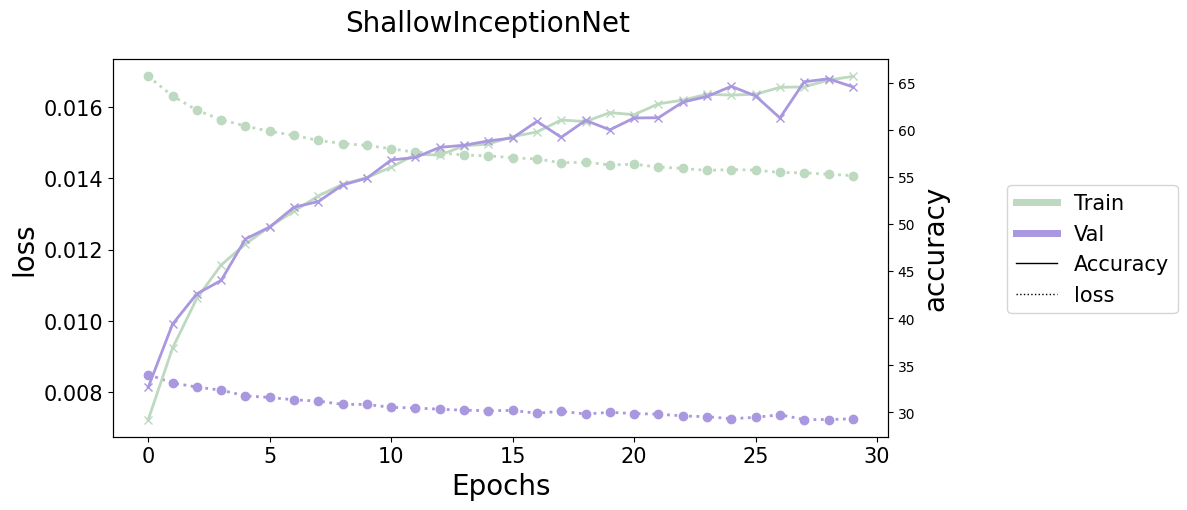

In [21]:
plot_metrics(metrics, title="ShallowInceptionNet")

### Test set performance

In [22]:
# test set performance 
test_loss, test_acc = process(model, test_dataloader)

print(f"ShallowInceptionNet test dataset loss: {test_loss: 0.5f} \t accuracy: {100*test_acc: 2.3f}%")

ShallowInceptionNet test dataset loss:  0.00739 	 accuracy:  57.986%


## DenseNet

As explained in the [lessons](../lessons/mna-interactive.ipynb), DenseNet architecture has the following two main components:

- **DenseBlock**: It consists of layers, where each layer takes in, as an input channels, a concatenation of previous layers' (within the block) activations and outputs $k$ channels.
- **Transition Layers**: Each transition layer downsamples the receptive field and halves the number of channels from the previous DenseBlock. The output of this layer is fed further into the next DenseBlock.

Following implementation has been inspired from the [tutorial here](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html).

In [22]:
class DenseBlock(nn.Module):
    def __init__(self, c_in, n_layers, growth_rate, bn_factor=4):
        super().__init__()
        
        self.layers = []
        
        n_bn_channels = bn_factor * growth_rate
        
        for i in range(n_layers):
            self.layers.append(
                nn.Sequential(
                    nn.BatchNorm2d(c_in), 
                    nn.ReLU(),
                    nn.Conv2d(c_in, n_bn_channels, kernel_size=1), # 1x1 convolution; bottleneck  DenseNet-B
                    nn.BatchNorm2d(n_bn_channels),
                    nn.ReLU(),
                    nn.Conv2d(n_bn_channels, growth_rate, kernel_size=3, padding=1) # pad so that the size remains same
                )
            )
            c_in += growth_rate 
        
        self.layers = nn.ModuleList(self.layers)
    
    def forward(self, x):
        for layer in self.layers:
            z = layer(x)
            x = torch.cat([x, z], dim=1)
        return x
    
class TransitionLayer(nn.Module):
    """
    DenseNet-C: if theta = 0.5
    """
    def __init__(self, c_in, theta):
        
        super().__init__()
        
        self.transition = nn.Sequential(
            nn.BatchNorm2d(c_in),
            nn.Conv2d(c_in, int(theta * c_in), kernel_size=1), # reduces the channels
            nn.AvgPool2d(kernel_size=2, stride=2) # downsamples the receptive field
        )
        
    def forward(self, x):
        return self.transition(x)        

In [23]:
class DenseNet(nn.Module):
    """
    Args:
        c_in (int): number of channels in the input
        n_dense_layers (list): number of layers in each of the dense block
        growth_rate (int): number of channels in the output of each layer of the dense block
        num_classes (int): dimensions in the final output
        c_dense_in (int): number of channels after raw input transformation before entering the first dense block
        theta (float): reduction factor from channel outputs
        bn_factor (int): expansion factor for 1x1 convolution in layers of dense block
    """
    def __init__(self, c_in, n_dense_layers, growth_rate, num_classes=10, c_dense_in=16, theta=0.5, bn_factor=4):
        super().__init__()
        
        self.input_args = [c_in, n_dense_layers, growth_rate, num_classes, c_dense_in, theta, bn_factor]
        
        # input
        self.input_conv = nn.Sequential(
            nn.Conv2d(c_in, c_dense_in, kernel_size=3, padding=1) # no batchnorm or relu; denseblocks do it too. 
        )
        
        # 
        c_in = c_dense_in
        blocks = []
        for i, n_layers in enumerate(n_dense_layers):
            blocks.append(DenseBlock(c_in, n_layers, growth_rate, bn_factor))
            
            c_in += growth_rate * n_layers
            # transition input (no transition after the last denseblock)
            if i < len(n_dense_layers) - 1:
                blocks.append(TransitionLayer(c_in, theta))

                # update c_in
                c_in = int(theta * c_in)
            
        self.blocks = nn.Sequential(*blocks)
    
        # output module 
        self.output_softmax = nn.Sequential(
            nn.BatchNorm2d(c_in), # outputs from denseblock do not pass through activation
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(output_size=(1,1)), # kernel_size and stride are automatically inferred: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
            nn.Dropout(0.4),
            nn.Flatten(),
            nn.Linear(c_in, num_classes),
            nn.Softmax(dim=1)
        )
        
    
    def forward(self, x):
        x = self.input_conv(x)
        x = self.blocks(x)
        x = self.output_softmax(x)
        return x

### DenseNet-BC 

Table 2 of [Huang et al.](https://arxiv.org/pdf/1608.06993.pdf) contains several configurations of DenseNet as experimented by the authors. 
We will initialize DenseNet-BC(k=12) here. 

<img src="img/densenet-bc.png" width=1000>

Note that Depth in the table refers to total number of convolutional and linear in the network. 
A denseblock's single layer has 2 convolutional layers, contribution to a total of $2l$ layers in a single block. 
A transition layer has 1 convolutional layer. 
The input and output layers have 1 convolution and linear layer respectively. 

[Refer to the codebase here](https://github.com/liuzhuang13/DenseNet/blob/master/models/densenet.lua#L24) for how the authors compute number of layers in each denseblock based on the `Depth`. 

$$\text{number of layers in each dense block} = \frac{\text{depth} - 4}{3 * 2}$$

Thus, for a depth of 100, there are a total of 16 layer in each block.
This initialization yields 0.8M parameters as reported in the table above. 

In [24]:
# from Implementation Details (page 4) of https://arxiv.org/pdf/1608.06993.pdf
densenet_bc = DenseNet(c_in=input_shape[2], n_dense_layers=[16, 16, 16], growth_rate=12, theta=0.5)
pp_model_summary(densenet_bc)

Number of parameters:
  • input_conv     : 448
  • blocks         : 753420
  • output_softmax : 4090
total              : 757958
Total memory       : 0.0031 GB


In [27]:
densenet_bc, metrics = train(densenet_bc)

@ epoch 0	train_loss:  0.01434, train_acc: 62.438%,  val_loss: 0.00738, val_acc: 61.180%,
@ epoch 1	train_loss:  0.01430, train_acc: 63.059%,  val_loss: 0.00738, val_acc: 61.180%,
@ epoch 2	train_loss:  0.01429, train_acc: 62.945%,  val_loss: 0.00732, val_acc: 62.640%,
@ epoch 3	train_loss:  0.01426, train_acc: 63.355%,  val_loss: 0.00733, val_acc: 62.880%,
@ epoch 4	train_loss:  0.01418, train_acc: 64.492%,  val_loss: 0.00730, val_acc: 63.140%,
@ epoch 5	train_loss:  0.01420, train_acc: 64.270%,  val_loss: 0.00729, val_acc: 63.720%,
@ epoch 6	train_loss:  0.01420, train_acc: 64.133%,  val_loss: 0.00733, val_acc: 62.400%,
@ epoch 7	train_loss:  0.01419, train_acc: 64.391%,  val_loss: 0.00729, val_acc: 63.340%,
@ epoch 8	train_loss:  0.01413, train_acc: 65.113%,  val_loss: 0.00730, val_acc: 63.380%,
@ epoch 9	train_loss:  0.01415, train_acc: 64.770%,  val_loss: 0.00726, val_acc: 64.080%,
@ epoch 10	train_loss:  0.01412, train_acc: 65.078%,  val_loss: 0.00723, val_acc: 65.080%,
@ epoch 1

DenseNet-BC(k=12) test dataset loss:  0.00658 	 accuracy:  78.120%


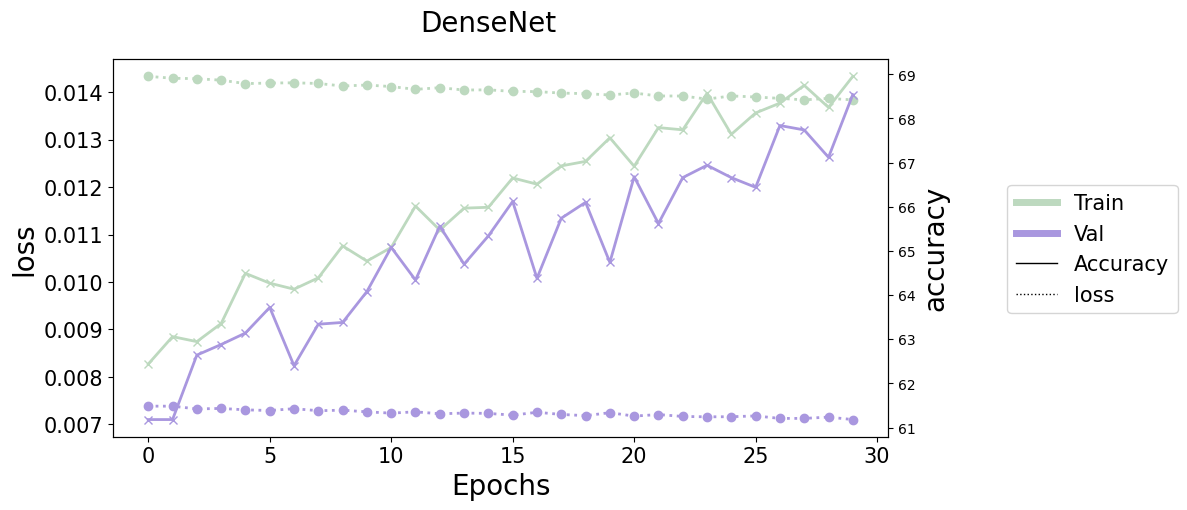

In [28]:
plot_metrics(metrics, title="DenseNet")
test_loss, test_acc = process(densenet_bc, test_dataloader)
print(f"DenseNet-BC(k=12) test dataset loss: {test_loss: 0.5f} \t accuracy: {100*test_acc: 2.3f}%")

### Training of DenseNet

Follow section 4.2 of [Huang et al.](https://arxiv.org/pdf/1608.06993.pdf) for the exact training details to achieve the similar error rates as reported in the table. 